# mtflib Demo: Magnetic Field Calculation and Validation

This Jupyter Notebook demonstrates the calculation of the magnetic field of a current ring using both serial and (optionally) MPI-parallel Biot-Savart law implementations within `mtflib`. This notebook is designed to be educational and easy to follow for new users, with detailed comments and explanations.

**Learning Objectives:**
- Understand how to set up and run `mtflib` simulations, including global settings and variable definition.
- Learn to utilize the electromagnetism extension to calculate magnetic fields using the Biot-Savart law.
- Explore both serial (`serial_biot_savart`) and MPI-parallel (`mpi_biot_savart`) computation options.
- Validate `mtflib` results by comparing them to analytical solutions.
- Interpret Taylor series coefficients to understand the behavior of the magnetic field.

**Prerequisites:**
- `mtflib` installed (follow installation instructions in the README).
- NumPy installed (`pip install numpy`).
- matplotlib installed (`pip install matplotlib`) for potential plotting.
- mpi4py installed (`pip install mpi4py`) if you want to run the MPI-parallel example.
- Jupyter Notebook or JupyterLab environment to run this notebook.

Let's get started!

## 1. Import Libraries and Initialize Global MTF Settings

We begin by importing the necessary Python libraries and functions from `mtflib`. Crucially, we initialize the global settings for Multivariate Taylor Functions. These settings, such as `max_order` and `max_dimension`, define the computational scope of `mtflib` for this session and should be set at the beginning of your script or notebook.

In [2]:
# Import necessary libraries
import numpy as np
from mtflib import MultivariateTaylorFunction, Var, integrate, sqrt_taylor, mtfarray, convert_to_mtf
from applications.em.biot_savart import mpi_biot_savart, serial_biot_savart
from applications.em.current_ring import current_ring
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Check if MTF globals are already initialized
if not MultivariateTaylorFunction.get_mtf_initialized_status():
    MultivariateTaylorFunction.initialize_mtf(max_order=6, max_dimension=4)
    MultivariateTaylorFunction.set_etol(1e-16)
else:
    print("MTF globals are already initialized. To change max_order or max_dimension, please restart the session.")

Initializing MTF globals with: _MAX_ORDER=6, _MAX_DIMENSION=4
Loading/Precomputing Taylor coefficients up to order 6
Global precomputed coefficients loading/generation complete.
Size of precomputed_coefficients dictionary in memory: 464 bytes, 0.45 KB, 0.00 MB
MTF globals initialized: _MAX_ORDER=6, _MAX_DIMENSION=4, _INITIALIZED=True
Max coefficient count (order=6, nvars=4): 210
Precomputed coefficients loaded and ready for use.


### 1a. Visualize the Geometry

Before performing the calculations, let's visualize the physical setup. We will plot the current ring and the axis along which we will calculate the magnetic field. This helps in understanding the geometry of the problem.

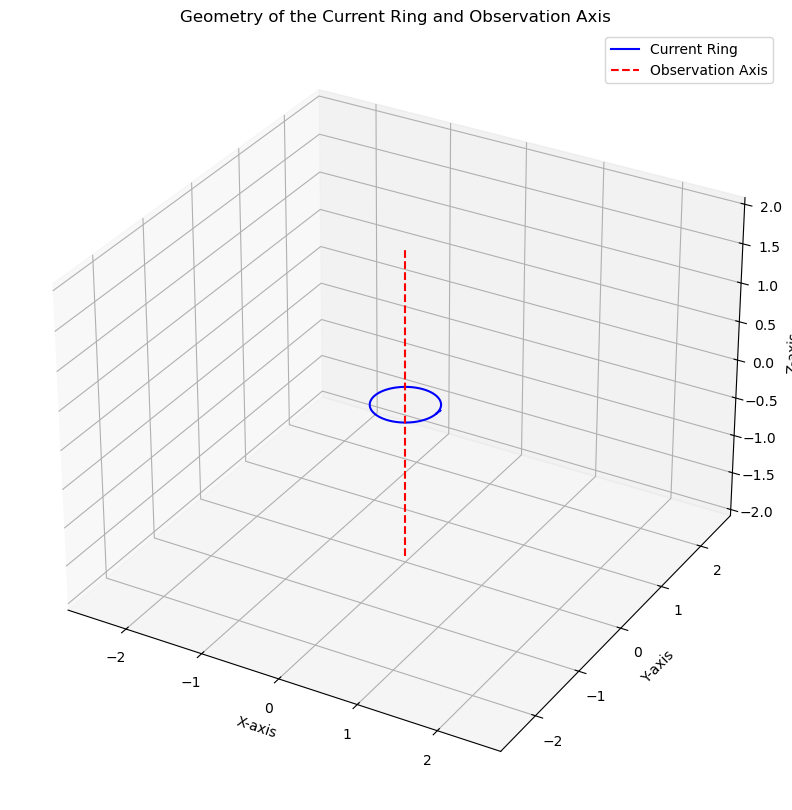

In [3]:
# --- Visualization Parameters ---
vis_ring_radius = 0.4
vis_ring_center = np.array([0.0, 0.0, 0.0])
vis_field_points_z = np.linspace(-2, 2, 50) # Use more points for a smooth line

# --- Create the 3D Plot ---
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the current ring
theta = np.linspace(0, 2 * np.pi, 100)
ring_x = vis_ring_radius * np.cos(theta)
ring_y = vis_ring_radius * np.sin(theta)
ring_z = np.zeros_like(theta) + vis_ring_center[2]
ax.plot(ring_x, ring_y, ring_z, 'b-', label='Current Ring')

# Add an arrow for current direction
ax.quiver(vis_ring_radius, 0, vis_ring_center[2], 0, 1, 0, length=0.1, normalize=True, color='b', arrow_length_ratio=0.4)

# Plot the axis for field calculation
ax.plot(np.zeros_like(vis_field_points_z), np.zeros_like(vis_field_points_z), vis_field_points_z, 'r--', label='Observation Axis')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Geometry of the Current Ring and Observation Axis')
ax.legend()
ax.axis('equal')
plt.show()

**Explanation:**
- We import `numpy` for numerical array handling, which is fundamental for `mtflib`'s efficient operations.
- From `mtflib` we import the core classes and functions including `MultivariateTaylorFunction`, `Var`, and other essential components for working with MTFs.
- We specifically import `mpi_biot_savart` and `serial_biot_savart` for calculating magnetic fields using the Biot-Savart law, and `current_ring` to define the geometry of our current source.
- `matplotlib.pyplot` and `mpl_toolkits.mplot3d` are imported for plotting and visualizing results.
- `initialize_mtf(max_order=6, max_dimension=4)`: This line is **critical**. It initializes the global settings for `mtflib`:
  - `max_order=6` sets the maximum order of Taylor expansions that will be computed. Higher order means potentially greater accuracy but also increased computational cost.
  - `max_dimension=4` defines the maximum number of independent variables our MTFs can have. For this electromagnetic example, we will use up to 4 variables to represent spatial coordinates and potentially other parameters.
- `set_etol(1e-16)`: Sets the global error tolerance. Coefficients in Taylor series with an absolute value smaller than this tolerance will be truncated to zero.

## 2. Define MTF Variables

Next, we define the symbolic variables that will represent the dimensions of our problem space within the Multivariate Taylor Functions. We use `Var(dimension_index)` to create these symbolic variables. These variables act as the independent variables in our Taylor expansions.

In [4]:
# --- Define Variables for MTF --- #
x = Var(1) # 'x' is the first variable, associated with dimension 1
y = Var(2) # 'y' is the second variable, dimension 2
z = Var(3) # 'z' is the third variable, dimension 3

**Explanation:**
- `x = Var(1)`: Creates a symbolic MTF variable named `x` which corresponds to the first dimension (index 1) in our MTF system.
- `y = Var(2)`: Creates variable `y` for the second dimension (index 2).
- `z = Var(3)`: Creates variable `z` for the third dimension (index 3).

These `Var` objects are now symbolic MTF variables that you can use in mathematical expressions.

## 3. MPI Parallelization Setup (Optional)

`mtflib`'s electromagnetism extension includes support for MPI-based parallel computation to speed up Biot-Savart calculations, especially for complex geometries or large numbers of field points. This section sets up MPI if the `mpi4py` library is installed. If `mpi4py` is not found, the code will default to serial execution. MPI parallelization is particularly beneficial for larger problems, but for this simple example, the performance difference might not be dramatic unless you increase the problem size significantly.

In [5]:
# --- MPI Setup --- #
mpi_installed = False
try:
    from mpi4py import MPI # Attempt to import the mpi4py library
    mpi_installed = True
except ImportError:
    mpi_installed = False  # If import fails (mpi4py not installed), set mpi_installed to False
    MPI = None             # Ensure MPI is set to None if import fails

mu_0_4pi = 1e-7 # Define constant mu_0 / 4pi (permeability of free space divided by 4pi)

if mpi_installed:
    comm = MPI.COMM_WORLD    # Get the MPI communicator for all processes
    rank = comm.Get_rank()   # Get the rank (ID) of the current process within the communicator
    size = comm.Get_size()   # Get the total number of processes in the communicator
    print(f"Running in MPI parallel mode with {size} processes.") # Print message indicating MPI parallel mode
    parallel_mode = True     # Set parallel_mode flag to True
else:
    print("Running in serial mode (mpi4py not installed).") # Print message indicating serial mode
    parallel_mode = False    # Set parallel_mode flag to False
    rank = 0                 # In serial mode, rank is always 0
    size = 1                 # In serial mode, size is always 1

Running in serial mode (mpi4py not installed).


**Explanation:**
- This section checks if `mpi4py` is installed. If it is, it initializes the MPI environment to enable parallel computations. If not, it defaults to serial computation.
- `mu_0_4pi = 1e-7`: Defines the constant μ₀/4π, which is a factor in the Biot-Savart law. Its value in SI units is exactly 10⁻⁷ H/m or N/A².
- The `if mpi_installed:` block initializes MPI communicator (`comm`), process rank (`rank`), and total process size (`size`) if MPI is available. It also sets `parallel_mode = True`.
- If `mpi4py` is not installed (`else` block), it prints a message indicating serial mode and sets `parallel_mode = False`, `rank = 0`, and `size = 1`.

## 4. Define Field Points for Magnetic Field Calculation

We define the points in space where we want to calculate the magnetic field. In this example, we'll calculate the field at a few points along the z-axis for demonstration. For a more comprehensive analysis, you would typically use a larger number of field points, potentially spanning a 2D or 3D grid.

In [6]:
# --- Example Field Points --- #
num_field_points_axis = 3 # Define a small number of field points for this example (increase for higher resolution)
z_axis_coords = np.linspace(-2, 2, num_field_points_axis) # Create evenly spaced z-coordinates along the z-axis, from -2 to 2
field_points_axis = np.array([[x*0, y*0, convert_to_mtf(zc)+z] for zc in z_axis_coords], dtype=object) # Define field points as MTFs along the z-axis
                                                                                   # x=0, y=0, z varies. dtype=object is crucial for MTF arrays

**Explanation:**
- `num_field_points_axis = 3`: Sets the number of field points to 3 for this example. For a real simulation or visualization, you would likely use a much larger number (e.g., 50, 100, or more) to get a smoother field representation.
- `z_axis_coords = np.linspace(-2, 2, num_field_points_axis)`: Generates 3 evenly spaced coordinate values along the z-axis, ranging from -2 to 2.
- `field_points_axis = np.array([...], dtype=object)`: This line defines the field points as MTFs. For each `zc` in `z_axis_coords`, it creates a 3-element list representing a 3D point in MTF form:
  - `x*0`, `y*0`: These terms effectively set the x and y components of our field points to zero MTFs. This means we are evaluating along lines where x=0 and y=0 (the z-axis).
  - `convert_to_mtf(zc)+z`: This sets the z-component. `zc` is a scalar z-coordinate converted to MTF, and `z` is our MTF variable. This allows us to evaluate the magnetic field as a function of position along the z-axis.
  - `dtype=object`: **Important:** When creating arrays of MTFs, you must specify `dtype=object` to ensure NumPy handles them as Python objects.

## 5. Example 1: Magnetic Field of a Current Ring (Element Input)

This example calculates the magnetic field of a current ring centered at the origin and oriented along the z-axis (axis of symmetry is the z-axis itself). We use the `current_ring` function to discretize the ring into segments and then compute the Biot-Savart law using these segments.

In [7]:
# --- Example 1: Current Ring with Specified Center and Axis (element input) --- #
print("\n--- Example 1: Current Ring with Specified Center and Axis (Element Input) ---")
ring_radius = 0.4 # Radius of the current ring for Example 1
num_segments_ring = 10 # Number of segments for ring discretization
ring_center_point = np.array([0.0, 0.0, 0.0]) # Center of the ring at the origin [0, 0, 0]
ring_axis_direction = np.array([0, 0, 1]) # Ring axis along the z-axis (direction [0, 0, 1])

# Generate MTF segments for the ring using current_ring function
segment_mtfs_ring, element_lengths_ring, direction_vectors_ring = current_ring(
    ring_radius, num_segments_ring, ring_center_point, ring_axis_direction)

if parallel_mode:
    # Calculate magnetic field using MPI-parallel Biot-Savart if MPI is enabled
    B_field_ring_axis = mpi_biot_savart(segment_mtfs_ring, element_lengths_ring, direction_vectors_ring, field_points_axis)
else:
    # Calculate magnetic field using serial Biot-Savart
    B_field_ring_axis = serial_biot_savart(segment_mtfs_ring, element_lengths_ring, direction_vectors_ring, field_points_axis)


--- Example 1: Current Ring with Specified Center and Axis (Element Input) ---


**Explanation:**
- This section defines the parameters for the current ring:
  - `ring_radius = 0.4`: Radius of the ring is set to 0.4 units.
  - `num_segments_ring = 10`: The ring is discretized into 10 segments for numerical approximation.
  - `ring_center_point = np.array([0.0, 0.0, 0.0])`: The ring's center is at the origin (0, 0, 0).
  - `ring_axis_direction = np.array([0, 0, 1])`: The axis of the ring is along the z-axis (perpendicular to the x-y plane).
- `current_ring(...)`: Calls the function to create MTF representations of the ring segments.
- The `if parallel_mode:` block chooses between `mpi_biot_savart` (if MPI is enabled) and `serial_biot_savart` (for serial computation) to calculate the magnetic field.

In [8]:
for i in range(num_field_points_axis):
    B_field_ring_axis[i] = [integrate(bfld, 4, -1, 1) for bfld in B_field_ring_axis[i]]

if rank == 0: # Only process with rank 0 (master process in MPI, or single process in serial) will execute the output section
    mid_point = num_field_points_axis//2
    print("Magnetic field along axis of rotated ring (Example 1 - Element Input, first point):")
    print(mtfarray(B_field_ring_axis[mid_point]))

    # Extract Bz component and restrict to z-axis
    Bzfldxyz = B_field_ring_axis[mid_point][2]
    Bzfld = Bzfldxyz.substitute_variable(1,0).substitute_variable(2,0)
    print('Bz field along z: \n', Bzfld)

    current = 1

    import math
    analytic_fun_expr = (mu_0_4pi*2*math.pi*(ring_radius**2)*current)/((z**2+ring_radius**2)*sqrt_taylor(z**2+ring_radius**2))
    print('Analytic_fun expression:\n',analytic_fun_expr)

    # --- Coefficient Comparison Table ---
    mtf_map = {tuple(exp): coeff for exp, coeff in zip(Bzfld.exponents, Bzfld.coeffs)}
    analytic_map = {tuple(exp): coeff for exp, coeff in zip(analytic_fun_expr.exponents, analytic_fun_expr.coeffs)}

    all_exponents = set(mtf_map.keys()) | set(analytic_map.keys()) # Union of exponents

    print("\nCoefficient Comparison Table:")
    print("----------------------------------------------------------------------------------")
    print(f"{'Exponent':<15} | {'Bzfld Coeff':<20} | {'Analytic Coeff':<20} | {'Error':<20}") # Wider columns
    print("----------------------------------------------------------------------------------")

    for exponent in sorted(list(all_exponents)): # Iterate through exponents in sorted order
        mtf_coeff_raw = mtf_map.get(exponent, 0.0) # Get MTF coefficient, default to 0 if not present
        analytic_coeff_raw = analytic_map.get(exponent, 0.0) # Get analytic coefficient, default to 0 if not present
        error_raw = mtf_coeff_raw - analytic_coeff_raw

        # Safely convert to float, handling potential NumPy arrays
        mtf_coeff = float(mtf_coeff_raw.item()) if isinstance(mtf_coeff_raw, np.ndarray) else float(mtf_coeff_raw)
        analytic_coeff = float(analytic_coeff_raw.item()) if isinstance(analytic_coeff_raw, np.ndarray) else float(analytic_coeff_raw)
        error = float(error_raw.item()) if isinstance(error_raw, np.ndarray) else float(error_raw)

        # Convert exponent tuple elements to standard Python int before string conversion
        exponent_list_int = [int(val) for val in exponent] # Convert np.int64 to int
        exponent_str = str(tuple(exponent_list_int)) # Convert tuple of ints to string

        print(f"{exponent_str:<15} | {mtf_coeff:<20.8e} | {analytic_coeff:<20.8e} | {error:<20.8e}") # Wider columns and consistent formatting

    print("----------------------------------------------------------------------------------")

Magnetic field along axis of rotated ring (Example 1 - Element Input, first point):
       Coefficient_1      Coefficient_2                           Coefficient_3  Order     Exponents
0 0.000000000000e+00 0.000000000000e+00  1.570796332545e-06+0.000000000000e+00j      0  (0, 0, 0, 0)
1 0.000000000000e+00 0.000000000000e+00 -1.472621561703e-05+0.000000000000e+00j      2  (0, 0, 2, 0)
2 0.000000000000e+00 0.000000000000e+00  1.150485595080e-04+0.000000000000e+00j      4  (0, 0, 4, 0)
3 0.000000000000e+00 0.000000000000e+00 -8.388957464128e-04+0.000000000000e+00j      6  (0, 0, 6, 0)
Bz field along z: 
                               Coefficient  Order     Exponents
0  1.570796332545e-06+0.000000000000e+00j      0  (0, 0, 0, 0)
1 -1.472621561703e-05+0.000000000000e+00j      2  (0, 0, 2, 0)
2  1.150485595080e-04+0.000000000000e+00j      4  (0, 0, 4, 0)
3 -8.388957464128e-04+0.000000000000e+00j      6  (0, 0, 6, 0)

Analytic_fun expression:
           Coefficient  Order     Exponents
0  1.5

C:\Users\manik\AppData\Local\Temp\ipykernel_13456\3883077244.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  mtf_coeff = float(mtf_coeff_raw.item()) if isinstance(mtf_coeff_raw, np.ndarray) else float(mtf_coeff_raw)
C:\Users\manik\AppData\Local\Temp\ipykernel_13456\3883077244.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  error = float(error_raw.item()) if isinstance(error_raw, np.ndarray) else float(error_raw)


**Explanation:**
- `if rank == 0:`: Ensures that the output and analysis section is executed only by the master process (rank 0) in MPI parallel mode, or by the single process in serial mode. This prevents redundant output from each process in parallel execution.
- `mid_point = num_field_points_axis//2`: Calculates the index of the middle field point in `field_points_axis` array. We will examine the magnetic field at this middle point as a representative example.
- **Integration and Substitution for 1D Bz field:**
  - `integrate(bfld, 4, -1, 1)`: Integrates the magnetic field components with respect to the 4th dimension (variable `u`) from -1 to 1.
  - `Bzfld = Bzfldxyz.substitute_variable(1,0).substitute_variable(2,0)`: Substitutes `x=0` (dimension 1) and `y=0` (dimension 2) into the MTF. This effectively restricts the MTF to be a function of only the z-coordinate (dimension 3), as we are interested in the Bz field along the z-axis.
- **Analytical Comparison:**
  - `analytic_fun_expr = ...`: Defines the analytical expression for the magnetic field along the axis of a current loop. This formula is derived from classical electromagnetism.
  - **Coefficient Comparison Table:** The code compares the coefficients of the Taylor expansion of the Bz field calculated by `mtflib` (`Bzfld`) with the Taylor expansion coefficients of the analytical solution (`analytic_fun_expr`). It generates a table that shows the exponents, the coefficients from both `mtflib` and the analytical solution, and the error (difference) between them. This table is crucial for validating the accuracy of the `mtflib` computation.

## 6. Further Exploration

This notebook provides a basic demonstration of magnetic field calculation using `mtflib`. You can extend this example and explore more features of the library by:

- **Varying Ring Parameters:** Experiment with different values for `ring_radius`, `num_segments_ring`, `ring_center_point`, and `ring_axis_direction` to see how these parameters affect the magnetic field.
- **Calculating Fields in 2D or 3D:** Modify `field_points_axis` to define field points on a plane (e.g., the x-y plane) or in a 3D volume to map the magnetic field in space.
- **Increasing Taylor Expansion Order:** Increase `max_order` in `initialize_mtf` to compute higher-order Taylor expansions for potentially increased accuracy (at the cost of computation time).
- **Exploring Other Electromagnetism Features:** Investigate other functions in the electromagnetism extension, such as those for calculating vector potential or magnetic forces.
- **Visualizing Results:** Use `matplotlib` to plot the magnetic field components as functions of position based on the MTF results. You can evaluate the MTFs at a range of numerical points and then plot these values.
- **Investigating Performance:** If you have `mpi4py` installed, compare the execution time of `serial_biot_savart` and `mpi_biot_savart` for larger problems to observe the benefits of parallelization.

Remember to consult the `mtflib` documentation, the `demos` directory, and the `tests` directory for more examples and advanced usage patterns.